In [1]:
from openprompt.data_utils import InputExample
import torch
import pandas as pd
import os
import json, csv
from abc import ABC, abstractmethod
from collections import defaultdict, Counter
from typing import List, Dict, Callable

from openprompt.utils.logging import logger

from openprompt.data_utils.utils import InputExample
from openprompt.data_utils.data_processor import DataProcessor
from openprompt import PromptDataLoader
from openprompt.prompts import ManualVerbalizer, ManualTemplate, SoftVerbalizer

from openprompt.plms.seq2seq import T5TokenizerWrapper, T5LMTokenizerWrapper
from transformers import T5Config, T5Tokenizer, T5ForConditionalGeneration
from openprompt.data_utils.data_sampler import FewShotSampler
from openprompt.plms import load_plm

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.utils.class_weight import compute_class_weight

from torchnlp.encoders import LabelEncoder

from collections import Counter
from loguru import logger

# first set up the dataprocessor for mortality prediction

In [2]:
# set dir to the mortality prediction data
data_dir = "../clinical-outcomes-data/mimic3-clinical-outcomes/mp/"

In [4]:
df = pd.read_csv(f"{data_dir}/train.csv")

In [4]:
len(df.id.unique())

33954

In [5]:
df

,id,text,hospital_expire_flag
0,107384,"CHIEF COMPLAINT: AMS, concern for toxic alcoho...",0
1,101061,CHIEF COMPLAINT: abdominal pain\n\nPRESENT ILL...,0
2,127180,CHIEF COMPLAINT: Bilateral Sub Dural Hematoma\...,0
3,168339,CHIEF COMPLAINT: Intracranial bleed\n\nPRESENT...,0
4,154044,CHIEF COMPLAINT: ischemic left foot\n\nPRESENT...,0
...,...,...,...
33949,122869,CHIEF COMPLAINT: Fever and neutropenia.\n\nPRE...,0
33950,145612,CHIEF COMPLAINT: Chest pain.\n\nPRESENT ILLNES...,0
33951,152495,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: The pati...,0
33952,182652,"CHIEF COMPLAINT: Malaise, fever, chills, and L...",0


In [14]:
df.loc[0]['text']

'CHIEF COMPLAINT: AMS, concern for toxic alcohol ingestion\n\nPRESENT ILLNESS: Mr. [**Known lastname 27389**] is a 39 year old man with h/o EtOH and polysubstance abuse, seizure disorder, who was found to be unresponsive while visiting his partner in the ICU earlier today. . The patient was visiting his partner in the ICU earlier today. He was awake and conversant in the morning with no acute complaints. He was noted to be sleeping on the floor, but walked to the chair by himself when he was awakened. Later in the afternoon, the patient was noted to still be asleep in the chair. He was unarousable with verbal stimuli or sternal rub, so he was taken down to the ED. . In the ED, the patient was initially altered, but was otherwise hemodynamically stable. No urine incontinence or e/o toxidromes. Labs notable for EtOH 86, Osms 366, anion gap 16, lactate 3.8. Utox positive for barbs, but Stox and Utox otherwise negative. Given high serum osmolar gap (60), toxicology was consulted for concer

<AxesSubplot:>

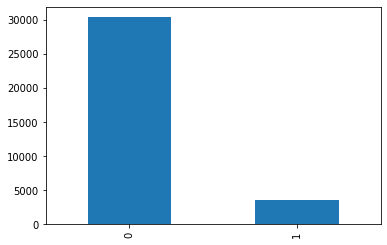

In [17]:
df.hospital_expire_flag.value_counts().plot(kind="bar")

In [6]:
# we actually want to convert the numerical labels to string 

df["label"] = df["hospital_expire_flag"].map({0:"alive",1:"deceased"})

In [25]:
df.hospital_expire_flag.unique()

array([0, 1])

In [11]:
len(df[df["hospital_expire_flag"]==1])

3534

In [32]:
    
g = df.groupby('hospital_expire_flag')
g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min(), random_state = 42).reset_index(drop=True)))
g.reset_index(drop=True, inplace = True)

In [33]:
g.sort_values(by="id")

,id,text,hospital_expire_flag,label
3448,100035,"CHIEF COMPLAINT: Post-cardiac arrest, asthma e...",0,alive
38,100045,CHIEF COMPLAINT: Mental status changes\n\nPRES...,0,alive
5534,100053,CHIEF COMPLAINT: Hypotension\n\nPRESENT ILLNES...,1,deceased
5650,100074,CHIEF COMPLAINT: bruising and some mild abdomi...,1,deceased
5269,100087,CHIEF COMPLAINT: s/p PEA arrest\n\nPRESENT ILL...,1,deceased
...,...,...,...,...
988,199923,"CHIEF COMPLAINT: Asymptomatic, positive stress...",0,alive
1198,199928,CHIEF COMPLAINT: Chest pain\n\nPRESENT ILLNESS...,0,alive
2936,199931,CHIEF COMPLAINT: \n\nPRESENT ILLNESS: The pati...,0,alive
3618,199949,CHIEF COMPLAINT: worsening weakness\n\nPRESENT...,1,deceased


# lets create a balanced train and test set  - with this imbalance models will likely just predict 0 and achieve top metrics

In [4]:
def balance_dataset(df, random_state = 42):
    
    '''
    Function to balance the training dataset - won't bother with the valid and test sets
    
    
    '''   
    
    
    # slightly clunky but works
    g = df.groupby('hospital_expire_flag')
    g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min(), random_state = random_state).reset_index(drop=True)))
    g.reset_index(drop=True, inplace = True)
    
    return g.sample(frac=1, random_state=random_state).reset_index(drop=True)
    

In [35]:
df_balanced = balance_dataset(df)
df_balanced

,id,text,hospital_expire_flag,label
0,173107,CHIEF COMPLAINT: Abdominal Pain\n\nPRESENT ILL...,1,deceased
1,191441,CHIEF COMPLAINT: Dyspnea\n\nPRESENT ILLNESS: 7...,0,alive
2,195302,CHIEF COMPLAINT: Septic shock\n\nPRESENT ILLNE...,1,deceased
3,198997,CHIEF COMPLAINT: Jaw pain.\n\nPRESENT ILLNESS:...,0,alive
4,109535,CHIEF COMPLAINT: Syncope\n\nPRESENT ILLNESS: T...,0,alive
...,...,...,...,...
7063,157346,CHIEF COMPLAINT: ICH\n\nPRESENT ILLNESS: The p...,1,deceased
7064,131615,CHIEF COMPLAINT: Wake board accident with open...,1,deceased
7065,129632,CHIEF COMPLAINT: asystolic arrest\n\nPRESENT I...,1,deceased
7066,154156,CHIEF COMPLAINT: Shortness of Breath\n\nPRESEN...,1,deceased


In [3]:
class Mimic_Mortality_Processor(DataProcessor):


    '''
    Function to convert mimic mortality prediction dataset from the clinical outcomes paper: https://aclanthology.org/2021.eacl-main.75/
    
    to a open prompt ready dataset. 
    
    We also instantiate a LabelEncoder() class which is fitted to the given dataset. Fortunately it appears
    to create the same mapping for each set, given each set contains all classes.    
    
    '''
    # TODO Test needed
    def __init__(self):
        super().__init__()   
        
    def get_ce_class_weights(self,df):
        
        '''
        Function to calculate class weights to pass to cross entropy loss in pytorch framework.
        
        Here we use the sklearn compute_class_weight function.
        
        Returns: un-normalized class weights inverse to sample size. i.e. lower number given to majority class
        '''

        # calculate class weights 
        ce_class_weights = compute_class_weight("balanced", classes = np.unique(df["hospital_expire_flag"]),
                                             y = df['hospital_expire_flag'] )

        return ce_class_weights
    
    def get_weighted_sampler_class_weights(self, df, normalized = True):
        
        '''
        Function to create array of per sample class weights to pass to the weighted random sampler.
        
        Purpose is to create batches which sample from the entire dataset based on class weights ->
        this attempts to create balanced batches during training.
        
        DO NOT SHUFFLE DATASET WHEN TRAINING - use weightedrandomsampler
        '''
        
        if normalized:
            nSamples = df["hospital_expire_flag"].value_counts()
            class_weights = [1 - (x / sum(nSamples)) for x in nSamples]
            
        # can use the class weights derived from the get_ce_class weights function
        else:
            class_weights = self.get_ce_class_weights(df)
        
        # creata dict for easy mapping
        class_weights_dict = {0:class_weights[0], 1:class_weights[1]}        
        
        # then need to assign these class specific weights to each sample based on their class
        class_weights_array = df["hospital_expire_flag"].map(class_weights_dict)
        
        return class_weights_array
        
        
        
        
    def balance_dataset(self,df, random_state = 42):
    
        '''
        Function to balance the training dataset - won't bother with the valid and test sets


        '''   


        # slightly clunky but works
        g = df.groupby('hospital_expire_flag')
        g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min(), random_state = random_state).reset_index(drop=True)))
        g.reset_index(drop=True, inplace = True)

        return g.sample(frac=1, random_state=random_state)

    def get_examples(self, data_dir, mode = "train", label_encoder = None,
                     generate_class_labels = False, class_labels_save_dir = "./scripts/mimic_mortality/",
                     balance_data = False, class_weights = False, sampler_weights = False):

        path = f"{data_dir}/{mode}.csv"
        print(f"loading {mode} data")
        print(f"data path provided was: {path}")
        examples = []
        df = pd.read_csv(path)
        
        # if balance data - balance based on minority class
        
        if balance_data:
            df = self.balance_dataset(df)

        # map the binary classification label to a new string class label
        df["label"] = df["hospital_expire_flag"].map({0:"alive",1:"deceased"})
        
        # need to either initializer and fit the label encoder if not provided
        if label_encoder is None:
            self.label_encoder = LabelEncoder(np.unique(df["label"]).tolist(),reserved_labels = [])
        else: 
            print("we were given a label encoder")
            self.label_encoder = label_encoder
            
        # calculate class_weights
        if class_weights:
            print("getting class weights")
            task_class_weights = self.get_ce_class_weights(df)
        
        # calculate all sample weights for weighted sampler
        if sampler_weights:
            print("getting weights for sampler!")
            sampler_class_weights = self.get_weighted_sampler_class_weights(df)

        print("label encoder idx to token: ", self.label_encoder.token_to_index)
        for idx, row in tqdm(df.iterrows()):
#             print(row)
            body, label = row['text'],row['label']
            label = self.label_encoder.encode(label)
            
            text_a = body.replace('\\', ' ')

                
            example = InputExample(
                guid=str(idx), text_a=text_a, label=int(label))
            examples.append(example)
            
        logger.info(f"Returning {len(examples)} samples!") 

#         now we want to return a list of the non-encoded labels based on the fitted label encoder
        if generate_class_labels:
        
            if not os.path.exists(class_labels_save_dir):
                os.makedirs(class_labels_save_dir)
            logger.info(f"Saving class labels to: {class_labels_save_dir}")
            class_labels = self.generate_class_labels()
            # write these to files as the classes for prompt learning pipeline           

            textfile = open(f"{class_labels_save_dir}/labels.txt", "w")

            for element in class_labels[:-1]:

                textfile.write(element + "\n")
            # now write the last item to the file
            textfile.write(class_labels[-1])
            textfile.close()
            
        if class_weights and sample_weights:
            print("cannot return both class and sample weights. Just returning samples")
            return examples
        if class_weights:
            return examples, task_class_weights
        elif sampler_weights:
            return examples, sampler_class_weights
        else:
            return examples

    def generate_class_labels(self):
        # now we want to return a list of the non-encoded labels based on the fitted label encoder
        try:
            return list(self.label_encoder.tokens.keys())
        except:
            print("No class labels as haven't fitted any data yet. Run get_examples first!")
            raise NotImplementedError

    
    def load_class_labels(self, file_path = "./scripts/mimic_mortality/labels.txt"):
        # function to load pre-generated class labels
        # returns list of class labels

        text_file = open(f"{file_path}", "r")

        class_labels = text_file.read().split("\n")

        return class_labels

In [6]:
# get different splits
dataset = {}
dataset['train'] = Mimic_Mortality_Processor().get_examples(data_dir = f"{data_dir}",
                                                                                 mode = "train",
                                                                                 class_weights = False,
                                                                                 sampler_weights = False)
dataset['valid'] = Mimic_Mortality_Processor().get_examples(data_dir = f"{data_dir}",mode = "valid" )
dataset['test'] = Mimic_Mortality_Processor().get_examples(data_dir = f"{data_dir}",mode = "test" )

loading train data
data path provided was: ../clinical-outcomes-data/mimic3-clinical-outcomes/mp//train.csv
label encoder idx to token:  {'alive': 0, 'deceased': 1}


33954it [00:02, 13289.76it/s]


loading valid data
data path provided was: ../clinical-outcomes-data/mimic3-clinical-outcomes/mp//valid.csv
label encoder idx to token:  {'alive': 0, 'deceased': 1}


4908it [00:00, 14947.03it/s]


loading test data
data path provided was: ../clinical-outcomes-data/mimic3-clinical-outcomes/mp//test.csv
label encoder idx to token:  {'alive': 0, 'deceased': 1}


9822it [00:00, 14731.67it/s]


In [6]:
len(dataset['train'])

500

In [8]:
class_labels = Mimic_Mortality_Processor().load_class_labels()

In [9]:
class_labels

['alive', 'deceased']

In [29]:
le = LabelEncoder(class_labels, reserved_labels = [])

In [30]:
le.tokens.keys()

dict_keys(['alive', 'deceased'])

In [31]:
le.token_to_index

{'alive': 0, 'deceased': 1}

# implementing weighted random sampler

First need to create a custom version of the PromptDataLoader - to very simple stop it overriding the sampler with None

We can now provide any pytorch dataloader sampler to the PromptDataLoader

In [83]:
from openprompt.data_utils import InputExample
import torch
import pandas as pd
import os
import json, csv
from abc import ABC, abstractmethod
from collections import defaultdict, Counter
from typing import List, Dict, Callable

from openprompt.utils.logging import logger

from openprompt.data_utils.utils import InputExample
from openprompt.data_utils.data_processor import DataProcessor

import pandas as pd
import numpy as np
from tqdm import tqdm

from torchnlp.encoders import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from torch.utils.data.sampler import RandomSampler, WeightedRandomSampler
from transformers.configuration_utils import PretrainedConfig
from transformers.generation_utils import GenerationMixin
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from typing import *
from openprompt.data_utils import InputExample, InputFeatures
from torch.utils.data._utils.collate import default_collate
from tqdm.std import tqdm
from transformers.tokenization_utils import PreTrainedTokenizer
from transformers.utils.dummy_pt_objects import PreTrainedModel
from openprompt.plms.utils import TokenizerWrapper
from openprompt.prompt_base import Template, Verbalizer
from collections import defaultdict
from openprompt.utils import round_list, signature
import numpy as np
from torch.utils.data import DataLoader
from yacs.config import CfgNode
from openprompt.utils.logging import logger
from transformers import  AdamW, get_linear_schedule_with_warmup

class customPromptDataLoader(object):
    
    def __init__(self, 
                 dataset: Union[Dataset, List],
                 template: Template,
                 tokenizer: PreTrainedTokenizer,
                 tokenizer_wrapper_class: TokenizerWrapper,
                 verbalizer: Optional[Verbalizer] = None,
                 max_seq_length: Optional[str] = 512,
                 batch_size: Optional[int] = 1,
                 shuffle: Optional[bool] = False,
                 teacher_forcing: Optional[bool] = False,
                 decoder_max_length: Optional[int] = -1,
                 predict_eos_token: Optional[bool] = False,
                 truncate_method: Optional[str] = "tail",
                 drop_last: Optional[bool] = False,
                 sampler: Optional[str] = None,
                 **kwargs,
                ):

        assert hasattr(dataset, "__iter__"), f"The dataset must have __iter__ method. dataset is {dataset}"
        assert hasattr(dataset, "__len__"), f"The dataset must have __len__ method. dataset is {dataset}"
        self.raw_dataset = dataset
        
        self.wrapped_dataset = []
        self.tensor_dataset = []
        self.template = template
        self.verbalizer = verbalizer
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.teacher_forcing = teacher_forcing

        tokenizer_wrapper_init_keys = signature(tokenizer_wrapper_class.__init__).args
        prepare_kwargs = {
            "max_seq_length" : max_seq_length,
            "truncate_method" : truncate_method,
            "decoder_max_length" : decoder_max_length,
            "predict_eos_token" : predict_eos_token,
            "tokenizer" : tokenizer,
            **kwargs,
        }
        to_pass_kwargs = {key: prepare_kwargs[key] for key in prepare_kwargs if key in tokenizer_wrapper_init_keys}
        

        self.tokenizer_wrapper = tokenizer_wrapper_class(**to_pass_kwargs)
        
        # check the satisfiability of each component
        assert hasattr(self.template, 'wrap_one_example'), "Your prompt has no function variable \
                                                         named wrap_one_example"
        
        # processs
        self.wrap()
        self.tokenize()

        if self.shuffle:
            sampler = RandomSampler(self.tensor_dataset)
        # else:
        #     sampler = None
        
        print(f"SAMPLER: {sampler}")
        self.dataloader = DataLoader(
            self.tensor_dataset, 
            batch_size = self.batch_size,
            sampler= sampler,
            collate_fn = InputFeatures.collate_fct,
            drop_last = drop_last,
        )
    
    
    def wrap(self):
        r"""A simple interface to pass the examples to prompt, and wrap the text with template.
        """
        if isinstance(self.raw_dataset, Dataset) or isinstance(self.raw_dataset, List): 
            assert len(self.raw_dataset) > 0, 'The dataset to be wrapped is empty.'
            # for idx, example in tqdm(enumerate(self.raw_dataset),desc='Wrapping'):
            for idx, example in enumerate(self.raw_dataset):
                if self.verbalizer is not None and hasattr(self.verbalizer, 'wrap_one_example'): # some verbalizer may also process the example.
                    example = self.verbalizer.wrap_one_example(example)
                wrapped_example = self.template.wrap_one_example(example)
                self.wrapped_dataset.append(wrapped_example)
        else:
            raise NotImplementedError
    
    def tokenize(self) -> None:
        r"""Pass the wraped text into a prompt-specialized tokenizer, 
           the true PretrainedTokenizer inside the tokenizer is flexible, e.g. AlBert, Bert, T5,...
        """
        for idx, wrapped_example in tqdm(enumerate(self.wrapped_dataset),desc='tokenizing'):
        # for idx, wrapped_example in enumerate(self.wrapped_dataset):
            inputfeatures = InputFeatures(**self.tokenizer_wrapper.tokenize_one_example(wrapped_example, self.teacher_forcing), **wrapped_example[1]).to_tensor()
            self.tensor_dataset.append(inputfeatures)
        
    def __len__(self):
        return  len(self.dataloader)

    def __iter__(self,):
        return self.dataloader.__iter__()

In [90]:
sampler = WeightedRandomSampler(train_class_weights, len(train_class_weights), replacement = True)

In [99]:
"WeightedRandom" in type(sampler).__name__
    

True

In [5]:
plm, tokenizer, model_config, WrapperClass = load_plm("bert", "bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
mytemplate = ManualTemplate(tokenizer=tokenizer).from_file(f"./scripts/mimic_mortality/manual_template.txt", choice=0)
myverbalizer = myverbalizer = ManualVerbalizer(tokenizer, classes=["alive","deceased"]).from_file(f"./scripts/mimic_mortality/manual_verbalizer.txt", choice=0)

In [102]:
batchsize = 4
max_seq_l = 480

train_dataloader = customPromptDataLoader(dataset=dataset["train"], template=mytemplate, tokenizer=tokenizer, 
    tokenizer_wrapper_class=WrapperClass, max_seq_length=max_seq_l, decoder_max_length=3, 
    batch_size=batchsize,shuffle=False, teacher_forcing=False, predict_eos_token=False,
    truncate_method="tail", sampler = WeightedRandomSampler(train_class_weights, len(train_class_weights),
                                                            replacement = True))

tokenizing: 500it [00:04, 101.90it/s]

SAMPLER: None


In [103]:
tot_alive = 0
tot_dead = 0
for i, (data) in enumerate(train_dataloader):
#     print(f"batch {i}: target:{data.label}")
    count = Counter(data.label.numpy())
    print(f"batch:{i}, 0/1 : {count[0]} / {count[1]}")
    tot_alive += count[0]
    tot_dead += count[1]

print(f"After all batches - total alive cases seen were: {tot_alive} and total dead were: {tot_dead}")
    

batch:0, 0/1 : 4 / 0
batch:1, 0/1 : 4 / 0
batch:2, 0/1 : 4 / 0
batch:3, 0/1 : 3 / 1
batch:4, 0/1 : 4 / 0
batch:5, 0/1 : 2 / 2
batch:6, 0/1 : 3 / 1
batch:7, 0/1 : 3 / 1
batch:8, 0/1 : 3 / 1
batch:9, 0/1 : 3 / 1
batch:10, 0/1 : 4 / 0
batch:11, 0/1 : 3 / 1
batch:12, 0/1 : 4 / 0
batch:13, 0/1 : 4 / 0
batch:14, 0/1 : 4 / 0
batch:15, 0/1 : 4 / 0
batch:16, 0/1 : 4 / 0
batch:17, 0/1 : 4 / 0
batch:18, 0/1 : 4 / 0
batch:19, 0/1 : 4 / 0
batch:20, 0/1 : 4 / 0
batch:21, 0/1 : 4 / 0
batch:22, 0/1 : 4 / 0
batch:23, 0/1 : 4 / 0
batch:24, 0/1 : 2 / 2
batch:25, 0/1 : 4 / 0
batch:26, 0/1 : 4 / 0
batch:27, 0/1 : 3 / 1
batch:28, 0/1 : 4 / 0
batch:29, 0/1 : 3 / 1
batch:30, 0/1 : 3 / 1
batch:31, 0/1 : 4 / 0
batch:32, 0/1 : 3 / 1
batch:33, 0/1 : 4 / 0
batch:34, 0/1 : 4 / 0
batch:35, 0/1 : 4 / 0
batch:36, 0/1 : 4 / 0
batch:37, 0/1 : 3 / 1
batch:38, 0/1 : 2 / 2
batch:39, 0/1 : 4 / 0
batch:40, 0/1 : 3 / 1
batch:41, 0/1 : 4 / 0
batch:42, 0/1 : 3 / 1
batch:43, 0/1 : 4 / 0
batch:44, 0/1 : 3 / 1
batch:45, 0/1 : 2 / 

# looking at the fewshot sampler



In [8]:
from openprompt.data_utils.data_sampler import FewShotSampler
support_sampler = FewShotSampler(num_examples_per_label = 100, also_sample_dev=False)
dataset['few_train'] = support_sampler(dataset['train'], seed=1)
dataset['few_valid'] = support_sampler(dataset['valid'], seed=1)
dataset['few_test'] = support_sampler(dataset['test'], seed=1)

In [10]:
dataset['few_train']

[{
   "guid": "21388",
   "label": 1,
   "meta": {},
   "text_a": "CHIEF COMPLAINT: shortness of breath\n\nPRESENT ILLNESS: 66 y/o M w/NSCLCa s/p RMSB stent [**5-21**], COPD, CRI, recent admits for respiratory failure with pneumothorax and CT placement, who was transferred to [**Hospital1 18**] from [**Hospital 4199**] Hospital for further evaluation of respiratory failure.  He was noted to be increasingly short of breath at home 5 days prior to admission here, and daughter was going to drive him to the hospital when he collapsed.  EMS was called, and he was intubated and brought to [**Last Name (un) 4199**].  His course there was significant for elevated WBC, creatinine 2.6, trop 0.23, AST 581, ALT 142.  He was presumed to have infection, [**Last Name (un) 7792**], and transaminitis [**1-19**] hypotension, ARF [**1-19**] hypovolemia.  His sputum grew MRSA.  He was supported with IVF, dopamine, vancomycin, was then weaned off pressors and transferred to [**Hospital1 18**].\n\nMEDICAL H

In [9]:
len(dataset['few_train']), len(dataset['few_valid']),len(dataset['few_test'])

(200, 200, 200)

In [22]:
batchsize = 4
max_seq_l = 480

support_dataloader = PromptDataLoader(dataset=dataset["support"], template=mytemplate, tokenizer=tokenizer, 
    tokenizer_wrapper_class=WrapperClass, max_seq_length=512, decoder_max_length=3, 
    batch_size=2,shuffle=False, teacher_forcing=False, predict_eos_token=False,
    truncate_method="tail")

tokenizing: 200it [00:01, 108.34it/s]


In [23]:
tot_alive = 0
tot_dead = 0
for i, (data) in enumerate(support_dataloader):
#     print(f"batch {i}: target:{data.label}")
    count = Counter(data.label.numpy())
#     print(f"batch:{i}, 0/1 : {count[0]} / {count[1]}")
    tot_alive += count[0]
    tot_dead += count[1]
    
print(f"total alive in entire dataset: {tot_alive} and total dead : {tot_dead}")

total alive in entire dataset: 100 and total dead : 100
